In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
train = pd.read_csv("../content/train.csv")
test = pd.read_csv("../content/test.csv")

In [3]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f05843a10>,
      dtype=object)

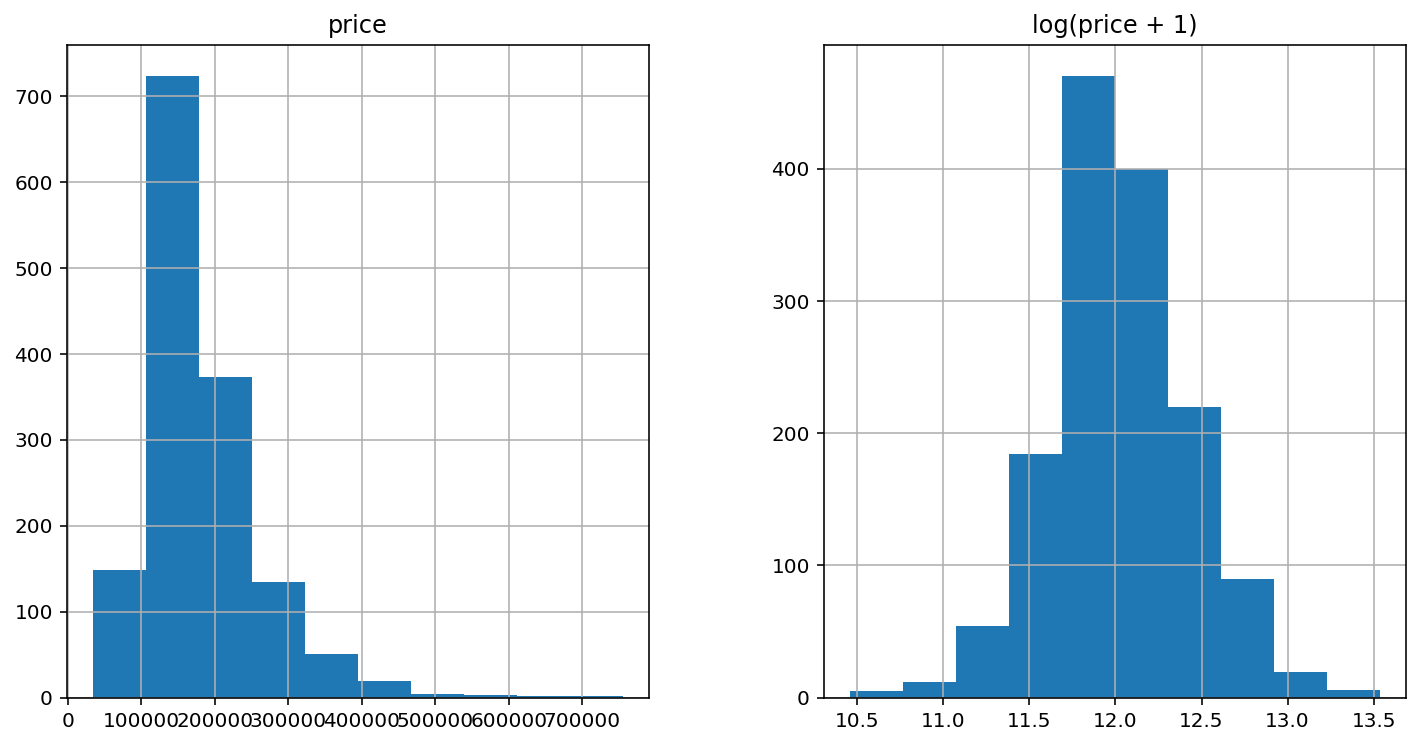

In [4]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [5]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [6]:
all_data = pd.get_dummies(all_data)

In [12]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [13]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [14]:
## Models

In [15]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [16]:
model_ridge = Ridge()

In [17]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

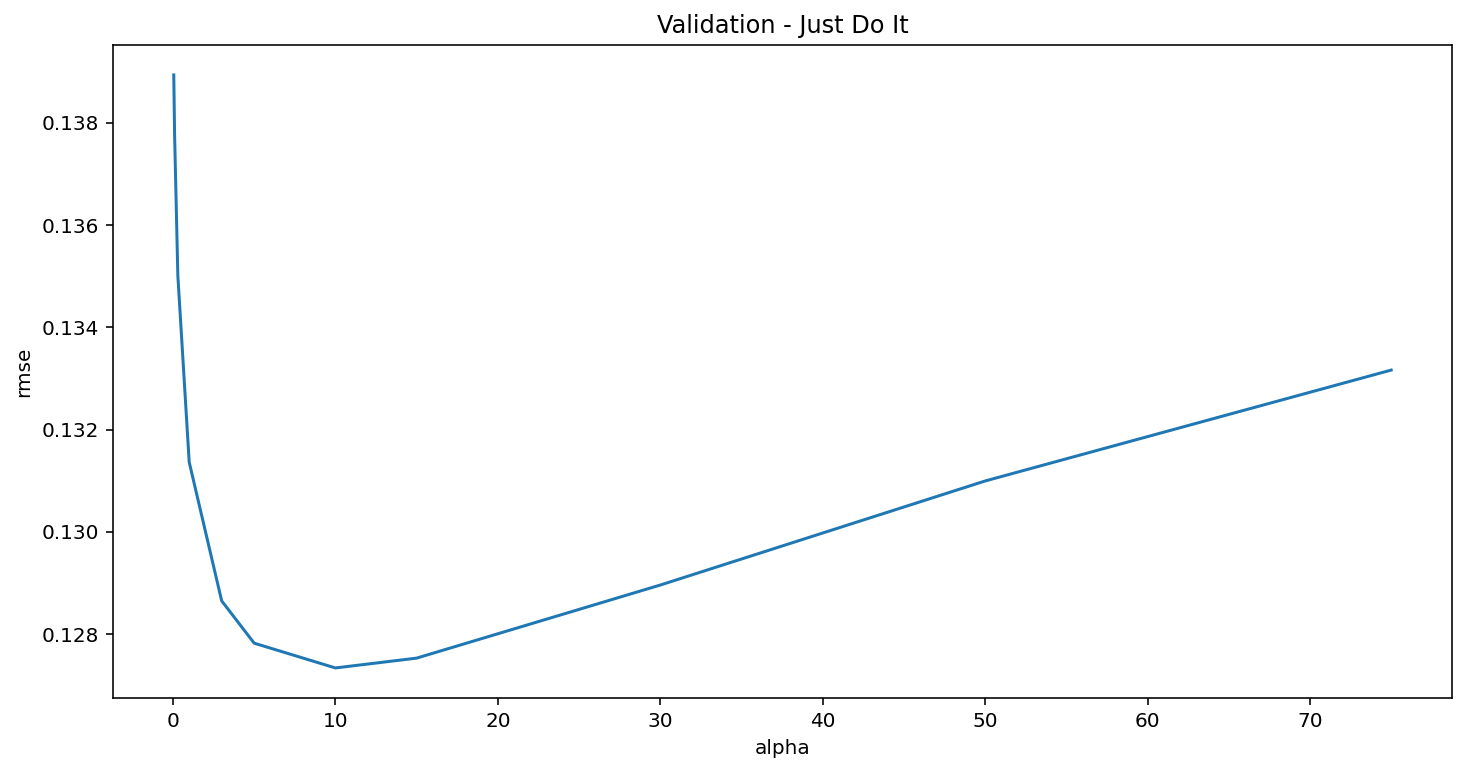

In [18]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [20]:
cv_ridge.min()

0.1273373466867076

In [21]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [22]:
rmse_cv(model_lasso).mean()

0.12256735885048142

In [28]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [29]:
coef

MSSubClass              -0.007480
LotFrontage              0.000000
LotArea                  0.071826
OverallQual              0.053160
OverallCond              0.043027
                           ...   
SaleCondition_AdjLand    0.000000
SaleCondition_Alloca    -0.000000
SaleCondition_Family    -0.007925
SaleCondition_Normal     0.019666
SaleCondition_Partial    0.000000
Length: 288, dtype: float64

In [31]:
sum(coef != 0 )

110

In [32]:
sum(coef==0)

178

In [33]:
imp_coef = pd.concat([coef.sort_values().head(10), 
                      coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Most & Least (10) important features from Lasso Model')

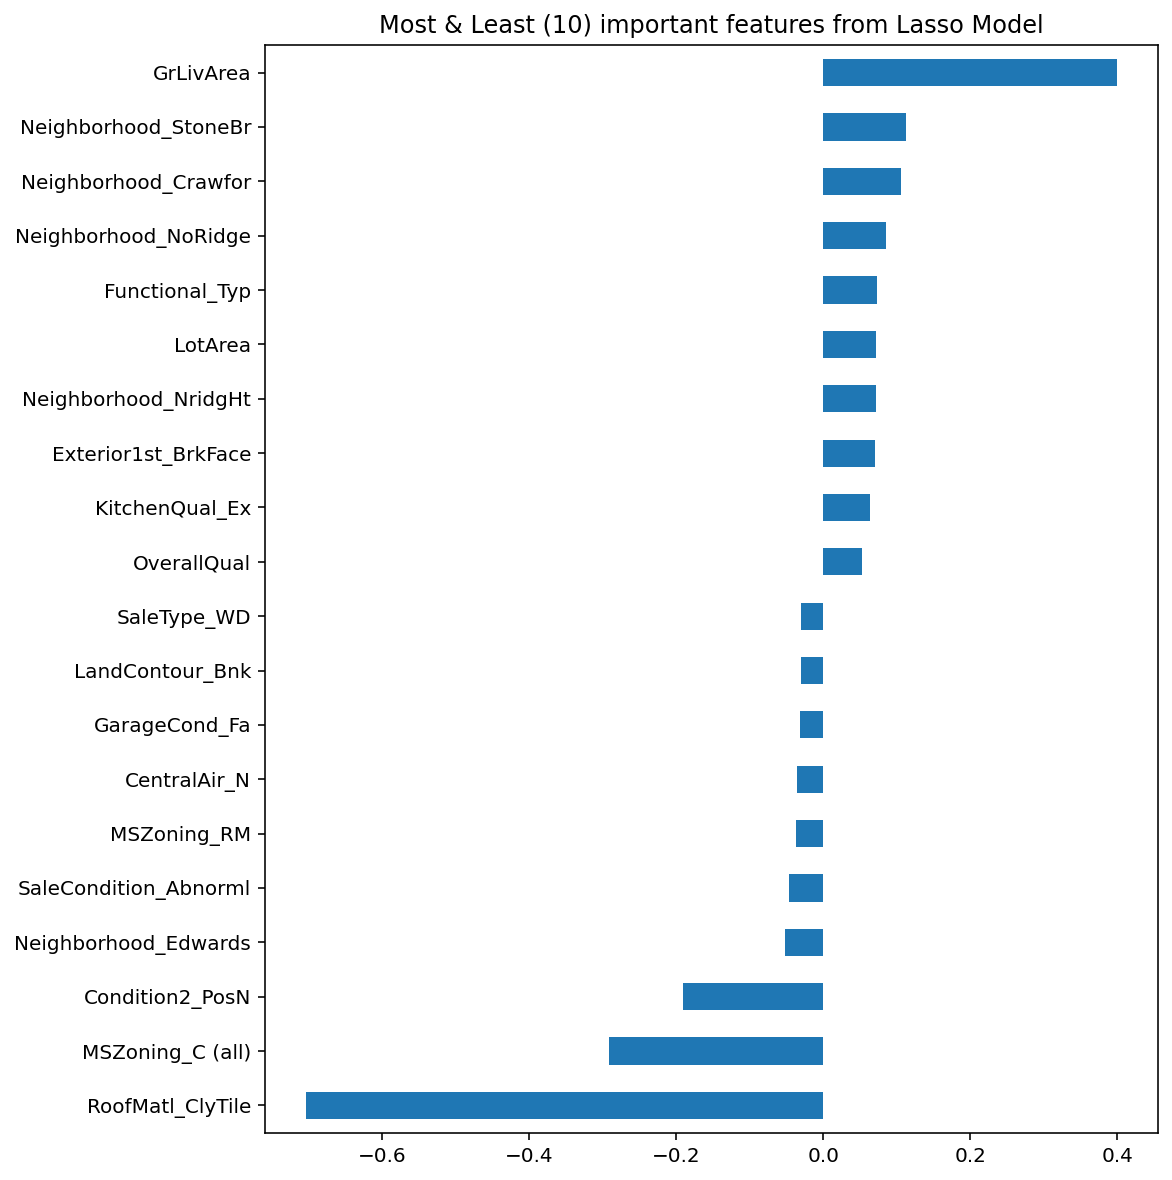

In [37]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)

imp_coef.plot(kind='barh')
plt.title('Most & Least (10) important features from Lasso Model')

In [38]:
### Residulas

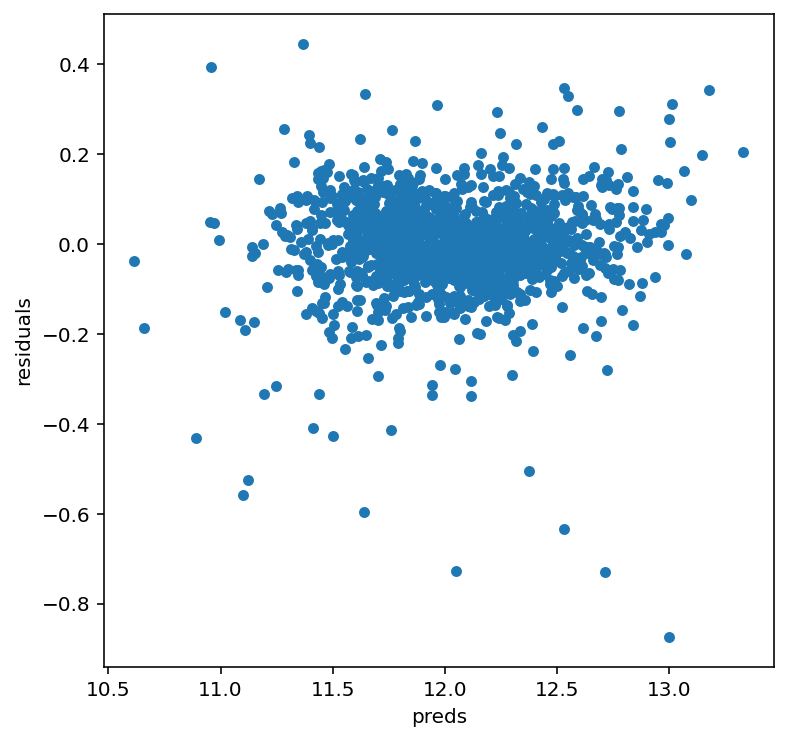

In [39]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({'preds':model_lasso.predict(X_train), 'true':y})
preds['residuals'] = preds['true'] - preds['preds']
preds.plot(x = 'preds', y = 'residuals', kind = 'scatter')